In [1]:
import os
import numpy as np
import pandas as pd
import cv2 # OpenCV
from alive_progress import alive_bar
import time
from pathlib import Path
from sklearn.svm import SVC # SVM klasifikator
from skimage.feature import hog as HOG
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import pickle
import math
%matplotlib inline

In [155]:
mask_on_classifier = pickle.load(open('mask_on_classifier.sav', 'rb'))
mask_off_classifier = pickle.load(open('mask_off_classifier.sav', 'rb'))
mask_classifier = pickle.load(open('mask_classifier.sav', 'rb'))

default_window_size = 40

image_name = "maksssksksss330.png"

img_base_path = str(Path().absolute()) + "\\archive\\images\\"

In [156]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

def classify_window(window, svm_classifier):
    features = HOG(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True).reshape(1, -1)
    result = svm_classifier.predict_proba(features);
    return result[0][1]

In [157]:
def process_image(image, step_size, window_size=(default_window_size, default_window_size), both_threshold=0.90, single_thresh=0.95):
    
    windows = []
    
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0], 3):
                score_mask_on = classify_window(window, mask_on_classifier)
                score_mask_off = classify_window(window, mask_off_classifier)
                
                if score_mask_off > both_threshold and score_mask_on > both_threshold:
                    if score_mask_off > single_thresh or score_mask_on > single_thresh:
                        window_images.append(window)
                        windows.append(this_window)
                    
    return windows

In [158]:
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [159]:
def NMS(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + default_window_size
    y2 = boxes[:,1] + default_window_size
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

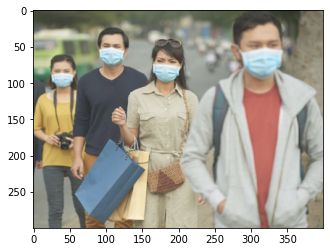

In [160]:
image = cv2.imread(img_base_path + image_name)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


window_images = []


#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


windows_grouped = []

pyramid_factor = 2

i = 1

while (image.shape[0] >= default_window_size and image.shape[1] >= default_window_size) and pyramid_factor >= i:
    
    windows = process_image(image, step_size=4)
    
    if len(windows) != 0:
        scale = int(math.pow(2, i-1))
            
        windows = np.c_[ windows, np.full((len(windows), 1), scale*default_window_size) ]
        windows = NMS(windows)
        if len(windows_grouped) == 0:
            windows_grouped = windows
        else:
            windows_grouped = np.vstack((windows_grouped, windows))
    
    image = cv2.pyrDown(image)
    i += 1


[[ 56 300  40]
 [ 84 296  40]
 [260 188  40]
 [212 172  40]
 [ 60 168  40]
 [ 36  92  40]
 [ 72  24  40]
 [  8 140  80]
 [ 16 104  80]
 [ 60  68  80]]
[1, 2, 3, 4, 5, 6, 7, 8, 9]


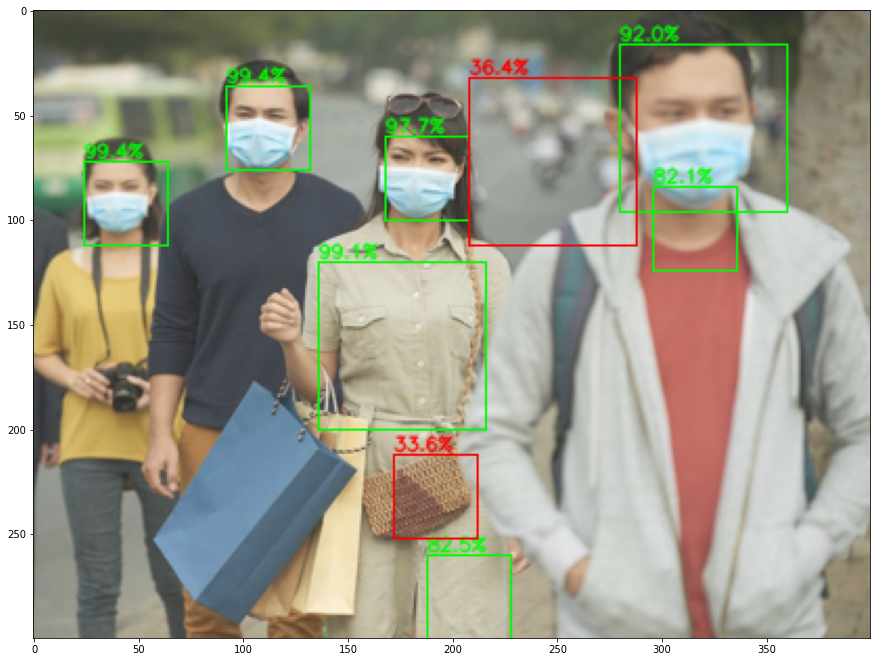

In [161]:
base_image = cv2.imread(img_base_path + image_name)

windows_grouped_nms = windows_grouped

print(windows_grouped_nms)

indx = []

for i in range(len(windows_grouped_nms)):
    indx.append(i)


for (x1,y1,d1) in windows_grouped_nms:
    
    scale1 = math.log(d1/default_window_size, 2) + 1
    i = -1
    
    for (x2,y2,d2) in windows_grouped_nms:
        i += 1
        
        if d1 == d2:
            continue
        
        if x1 == x2 and y1 == y2:
            continue
            
        if x2+d2/2 >= x1*scale1 and x2+d2/2 <= x1*scale1+d1 and y2+d2/2 >= y1*scale1 and y2+d2/2 <= y1*scale1+d1:
            try:
                indx.remove(i)
            except:
                pass

if len(indx) > 0:
    windows_grouped_nms = windows_grouped_nms[indx]
        
print(indx)

i = 1

#img = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)

for (x,y,d) in windows_grouped_nms:
    
    img=base_image
    scale = int(math.pow(2, i-1))
    
    while d != scale*default_window_size:
        img = cv2.pyrDown(img)
        i += 1
        scale = int(math.pow(2, i-1))
        
    score_mask = classify_window(img[x:x+default_window_size, y:y+default_window_size], mask_classifier)
    
    if score_mask > 0.7:
        image = cv2.rectangle(base_image,(y*scale,x*scale),(y*scale+d,x*scale+d),(0,250,0),1)
        image = cv2.putText(base_image, str(score_mask*100)[0:4] + '%', (y*scale,x*scale-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 250, 0), 1, cv2.LINE_AA)
    else:
        image = cv2.rectangle(base_image,(y*scale,x*scale),(y*scale+d,x*scale+d),(0,0,250),1)
        image = cv2.putText(base_image, str(score_mask*100)[0:4] + '%', (y*scale,x*scale-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 250), 1, cv2.LINE_AA)
        
    img = base_image
    i = 1

    
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))

Detecion precision:
0.3333333333333333


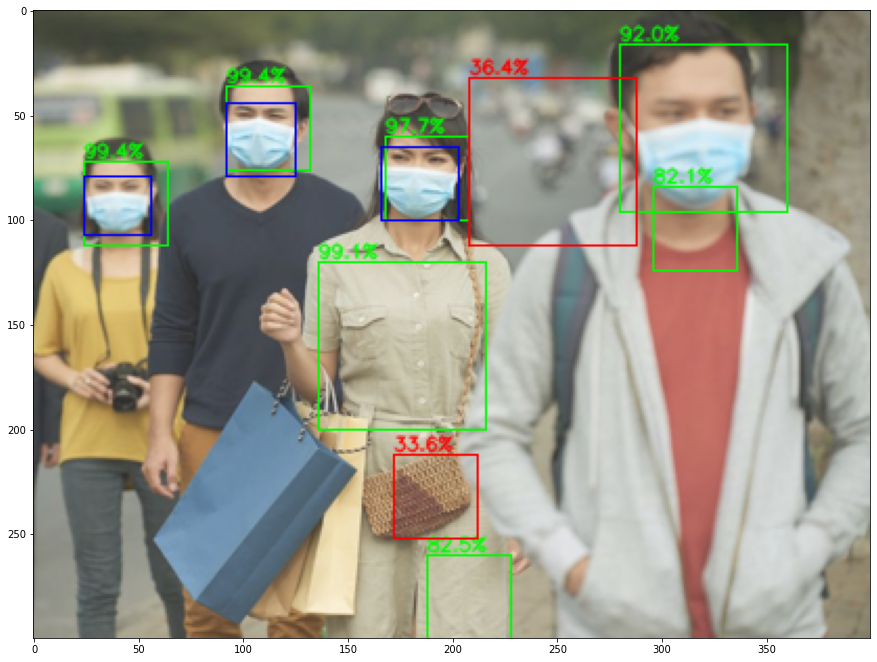

In [162]:
data = pd.read_csv(str(Path().absolute()) + "\\data.csv")

true_positive = []
false_positive = []

windows_test_precision = windows_grouped_nms

i = 1
indx = 0

indx_to_remove = []

for fileName in data['file']:

    if fileName == image_name and data["class"][indx] != -1:
        boxA = data.iloc[indx:indx+1,0:4].values.tolist()[0]
        
        image = cv2.rectangle(base_image,(boxA[0],boxA[1]),(boxA[2],boxA[3]),(250,0,0),1)
        
        wnds_indx = 0
        for (x,y,d) in windows_test_precision:
            
            img=base_image
            scale = int(math.pow(2, i-1))
            
            while d != scale*default_window_size:
                img = cv2.pyrDown(img)
                i += 1
                scale = int(math.pow(2, i-1))
            
            boxB = [y*scale, x*scale, y*scale+d, x*scale+d]
            iou = intersection_over_union(boxB, boxA)
            if iou > 0.5:
                indx_to_remove.append(wnds_indx)

            wnds_indx += 1
            i = 1
    indx += 1         
    
for indx in indx_to_remove:
    true_positive.append(windows_test_precision[indx])
    
indx = 0
for row in windows_test_precision:
    contains = False
    for indx2 in indx_to_remove:
        if indx2 == indx:
            contains = True
    if not contains:
        false_positive.append(row)
        
    indx += 1

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))


Precision = len(true_positive) / (len(true_positive) + len(false_positive))
print("Detecion precision:")
print(Precision)